### Я решил поменять датасет
___

### Библиотеки
___

In [53]:
import numpy as np
import pandas as pd
import holidays
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tqdm

### Анализ и подготовка данных
___

In [2]:
data = pd.read_csv("retail_store_inventory.csv")
data.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,20,Rainy,1,79.52,Spring


In [3]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

### Беру продажи в одном из регионов и убираю ненужные столбцы

In [4]:
data.Region.unique()

array(['North', 'South', 'West', 'East'], dtype=object)

In [ ]:
(
    len(data[data["Region"] == "North"]),
    len(data[data["Region"] == "South"]),
    len(data[data["Region"] == "West"]),
    len(data[data["Region"] == "East"]),
)

(18228, 18297, 18226, 18349)

### Беру East, выбрасываю ненужные колонки и добавляю признак - выше ли цена чем у конкурента (bool)

In [ ]:
data = data[data["Region"] == "East"]
data["Price_Higher_Than_Competitor"] = (
    data["Price"] > data["Competitor Pricing"]
).astype(int)
data = data.drop(
    columns=[
        "Store ID",
        "Region",
        "Inventory Level",
        "Units Ordered",
        "Demand Forecast",
        "Price",
        "Competitor Pricing",
        "Holiday/Promotion",
        "Seasonality",
    ]
)
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor
5078,2022-02-20,P0019,Electronics,66,0,Cloudy,0
36922,2023-01-05,P0003,Toys,93,5,Snowy,1
9725,2022-04-08,P0006,Clothing,448,10,Cloudy,0
25393,2022-09-11,P0014,Toys,75,10,Rainy,1
43402,2023-03-11,P0003,Toys,41,20,Rainy,1


In [7]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
country = "US"
# календарь праздников
country_holidays = holidays.US(years=2022)
data["Weekday"] = data["Date"].dt.weekday
data["Month"] = data["Date"].dt.month
data["Weekend"] = data["Date"].dt.dayofweek.isin([5, 6]).astype(int)
data["Holiday"] = data["Date"].isin(country_holidays).astype(int)

data["Tomorrow_Weekend_or_Holiday"] = (data["Date"] + pd.Timedelta(days=1)).apply(
    lambda x: int(x in country_holidays or x.dayofweek in [5, 6])
)


def holiday_within_7_days(date):
    for d in range(1, 8):
        check_date = date + timedelta(days=d)
        if check_date in country_holidays:
            return 1
    return 0


data["Holiday_Within_7_Days"] = data["Date"].apply(holiday_within_7_days)

/var/folders/g7/1pnn3np5387b0n86j69n94v40000gn/T/ipykernel_41358/1113601755.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["Holiday"] = data["Date"].isin(country_holidays).astype(int)


In [9]:
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
35192,2022-12-18,P0013,Clothing,262,10,Snowy,0,6,12,1,0,0,1
17657,2022-06-26,P0018,Electronics,92,20,Cloudy,1,6,6,1,0,0,0
40783,2023-02-12,P0004,Toys,155,5,Rainy,0,6,2,1,0,0,0
52687,2023-06-11,P0008,Electronics,66,20,Cloudy,0,6,6,1,0,0,0
55127,2023-07-06,P0008,Electronics,215,15,Cloudy,1,3,7,0,0,0,0


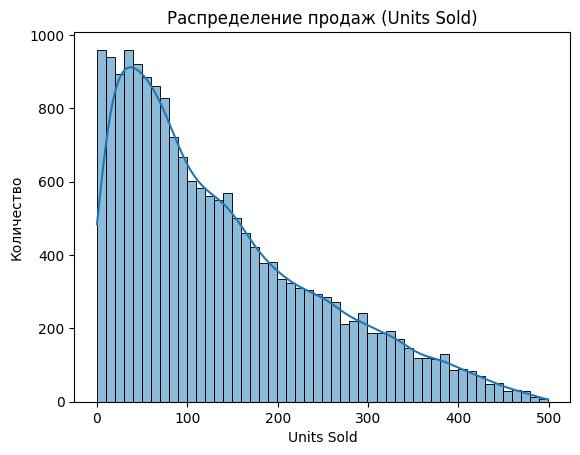

In [10]:
sns.histplot(data["Units Sold"], bins=50, kde=True)
plt.title("Распределение продаж (Units Sold)")
plt.xlabel("Units Sold")
plt.ylabel("Количество")
plt.show()

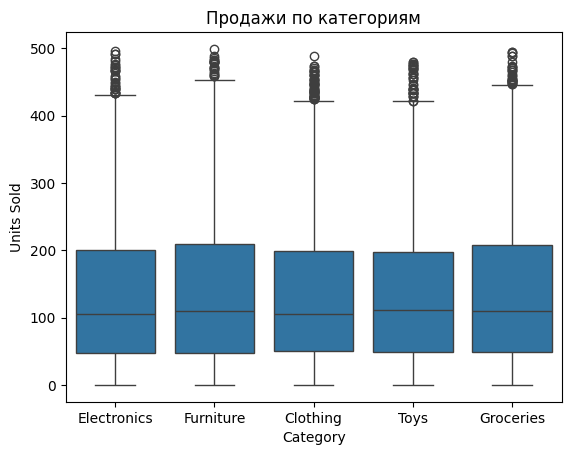

In [11]:
sns.boxplot(x="Category", y="Units Sold", data=data)
plt.title("Продажи по категориям")
plt.show()

/var/folders/g7/1pnn3np5387b0n86j69n94v40000gn/T/ipykernel_41358/1926896328.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Weekday", y="Units Sold", data=data, ci=None)


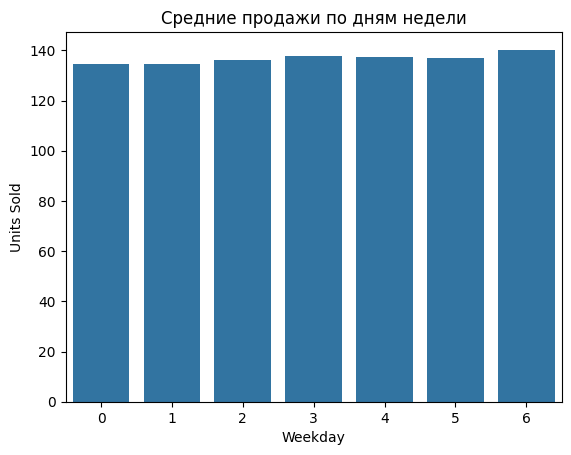

In [12]:
sns.barplot(x="Weekday", y="Units Sold", data=data, ci=None)
plt.title("Средние продажи по дням недели")
plt.show()

/var/folders/g7/1pnn3np5387b0n86j69n94v40000gn/T/ipykernel_41358/3987473319.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Month", y="Units Sold", data=data, ci=None)


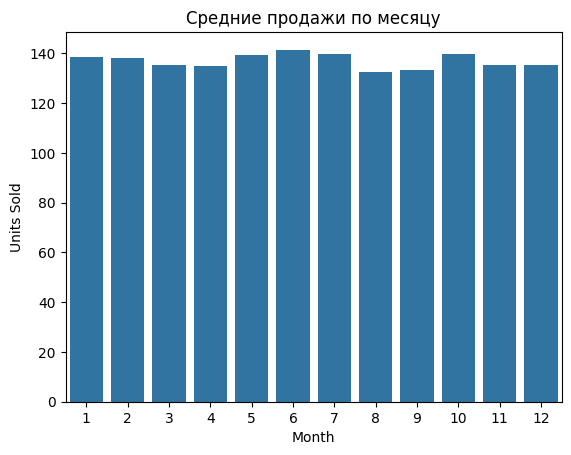

In [13]:
sns.barplot(x="Month", y="Units Sold", data=data, ci=None)
plt.title("Средние продажи по месяцу")
plt.show()

/var/folders/g7/1pnn3np5387b0n86j69n94v40000gn/T/ipykernel_41358/1662311033.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Weekend", y="Units Sold", data=data, ci=None)


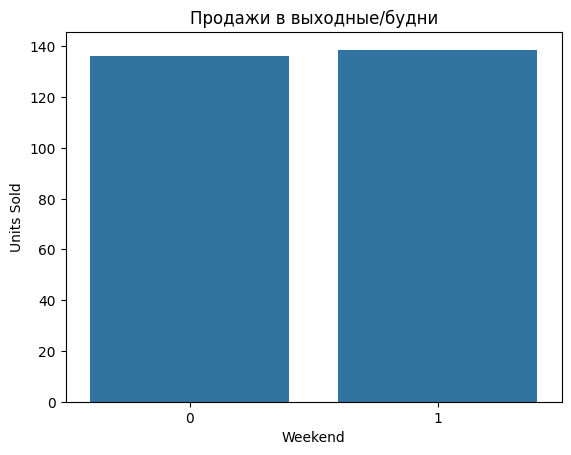

In [14]:
sns.barplot(x="Weekend", y="Units Sold", data=data, ci=None)
plt.title("Продажи в выходные/будни")
plt.show()

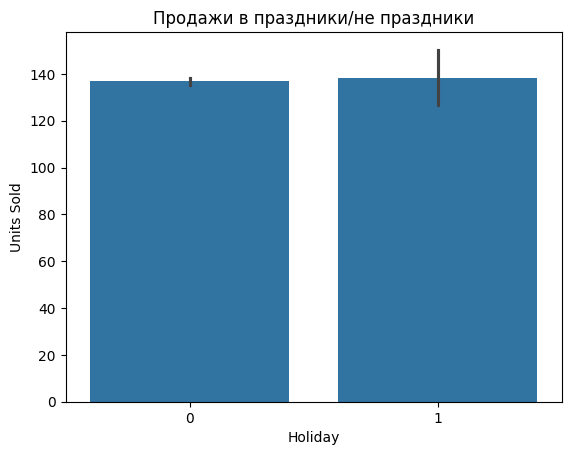

In [15]:
sns.barplot(x="Holiday", y="Units Sold", data=data)
plt.title("Продажи в праздники/не праздники")
plt.show()

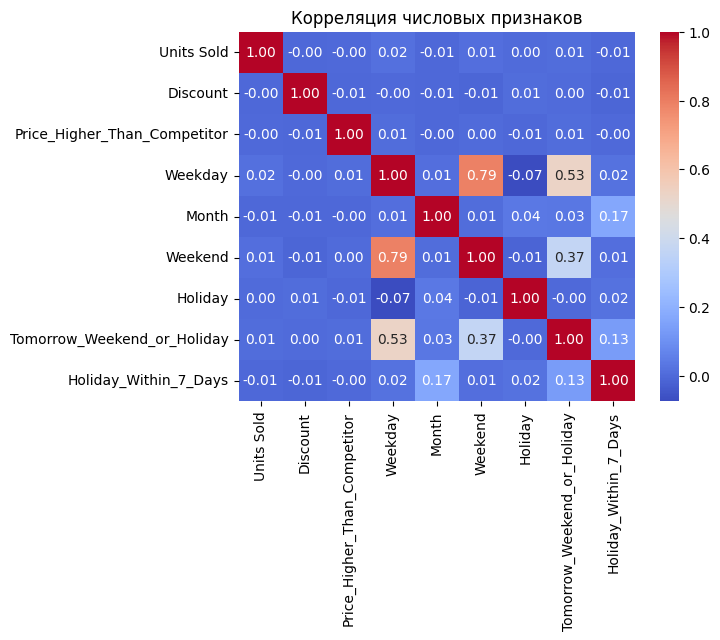

In [16]:
numeric_cols = data.select_dtypes(include="number").columns
corr = data[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция числовых признаков")
plt.show()

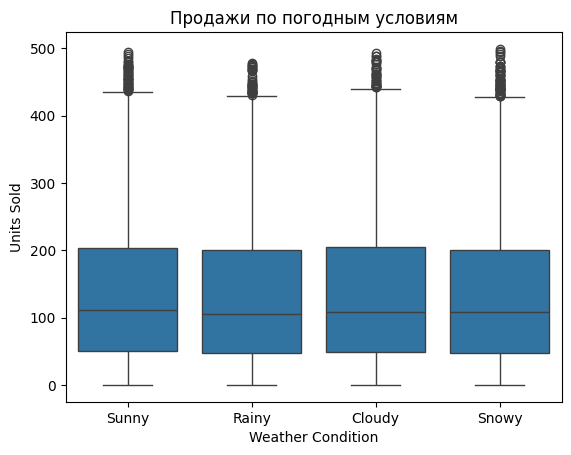

In [17]:
sns.boxplot(x="Weather Condition", y="Units Sold", data=data)
plt.title("Продажи по погодным условиям")
plt.show()

### Есть ощущение, что данные плохо нагенерены, но что поделать

### Фичи готовы, теперь энкодим, строим графики и смотрим на данные вообще

### сначала добавлю немного нанов в количество проданных единиц и заполню значения

In [18]:
n_missing = 100
missing_indices = np.random.choice(data.index, size=n_missing, replace=False)

data.loc[missing_indices, "Units Sold"] = np.nan

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18349 entries, 4 to 73099
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          18349 non-null  datetime64[ns]
 1   Product ID                    18349 non-null  object        
 2   Category                      18349 non-null  object        
 3   Units Sold                    18249 non-null  float64       
 4   Discount                      18349 non-null  int64         
 5   Weather Condition             18349 non-null  object        
 6   Price_Higher_Than_Competitor  18349 non-null  int64         
 7   Weekday                       18349 non-null  int32         
 8   Month                         18349 non-null  int32         
 9   Weekend                       18349 non-null  int64         
 10  Holiday                       18349 non-null  int64         
 11  Tomorrow_Weekend_or_Holiday   183

In [ ]:
group_cols = [
    "Product ID",
    "Price_Higher_Than_Competitor",
    "Weekend",
    "Holiday",
    "Tomorrow_Weekend_or_Holiday",
    "Holiday_Within_7_Days",
    "Month",
]

median_per_group = data.groupby(group_cols)["Units Sold"].median().dropna()
median_per_group

Product ID  Price_Higher_Than_Competitor  Weekend  Holiday  Tomorrow_Weekend_or_Holiday  Holiday_Within_7_Days  Month
P0001       0                             0        0        0                            0                      1        167.0
                                                                                                                2        156.5
                                                                                                                3        138.5
                                                                                                                4        158.0
                                                                                                                5        103.0
                                                                                                                         ...  
P0020       1                             1        0        1                            1                      10      

In [21]:
mask_nan = data["Units Sold"].isna()

for idx in data[mask_nan].index:
    key = tuple(data.loc[idx, group_cols])
    if key in median_per_group.index:
        data.at[idx, "Units Sold"] = median_per_group.loc[key]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18349 entries, 4 to 73099
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          18349 non-null  datetime64[ns]
 1   Product ID                    18349 non-null  object        
 2   Category                      18349 non-null  object        
 3   Units Sold                    18349 non-null  float64       
 4   Discount                      18349 non-null  int64         
 5   Weather Condition             18349 non-null  object        
 6   Price_Higher_Than_Competitor  18349 non-null  int64         
 7   Weekday                       18349 non-null  int32         
 8   Month                         18349 non-null  int32         
 9   Weekend                       18349 non-null  int64         
 10  Holiday                       18349 non-null  int64         
 11  Tomorrow_Weekend_or_Holiday   183

### осталось 6 nan, их просто удаляем

In [23]:
data = data.dropna(subset=["Units Sold"])

### Заполнили пропуски медианными значениями продаж таких же товаров с такими же значениями

In [24]:
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
24327,2022-09-01,P0008,Clothing,0.0,20,Rainy,1,3,9,0,0,0,1
40657,2023-02-11,P0018,Clothing,174.0,0,Sunny,0,5,2,1,0,1,0
60426,2023-08-28,P0007,Electronics,130.0,10,Rainy,0,0,8,0,0,0,1
19127,2022-07-11,P0008,Toys,88.0,5,Cloudy,0,0,7,0,0,0,0
50095,2023-05-16,P0016,Clothing,174.0,15,Snowy,1,1,5,0,0,0,0


In [25]:
for i in data.columns:
    print(f"{i}: {len(data[i].unique())}")

Date: 731
Product ID: 20
Category: 5
Units Sold: 512
Discount: 5
Weather Condition: 4
Price_Higher_Than_Competitor: 2
Weekday: 7
Month: 12
Weekend: 2
Holiday: 2
Tomorrow_Weekend_or_Holiday: 2
Holiday_Within_7_Days: 2


### Нужно энкодить Product id, category и Weather
я люблю targetecnoder, но сначала делим на train test

In [26]:
data.columns

Index(['Date', 'Product ID', 'Category', 'Units Sold', 'Discount',
       'Weather Condition', 'Price_Higher_Than_Competitor', 'Weekday', 'Month',
       'Weekend', 'Holiday', 'Tomorrow_Weekend_or_Holiday',
       'Holiday_Within_7_Days'],
      dtype='object')

In [ ]:
x = data[
    [
        "Product ID",
        "Category",
        "Discount",
        "Weather Condition",
        "Price_Higher_Than_Competitor",
        "Weekday",
        "Month",
        "Weekend",
        "Holiday",
        "Tomorrow_Weekend_or_Holiday",
        "Holiday_Within_7_Days",
    ]
]
y = data["Units Sold"]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [37]:
cat_cols = ["Product ID", "Category", "Weather Condition"]

In [ ]:
product_encoder = TargetEncoder()
x_train[["Product ID"]] = product_encoder.fit_transform(
    x_train[["Product ID"]], y_train
)
x_test[["Product ID"]] = product_encoder.transform(x_test[["Product ID"]])

In [39]:
category_encoder = TargetEncoder()
x_train[["Category"]] = category_encoder.fit_transform(x_train[["Category"]], y_train)
x_test[["Category"]] = category_encoder.transform(x_test[["Category"]])

In [ ]:
weather_encoder = TargetEncoder()
x_train[["Weather Condition"]] = weather_encoder.fit_transform(
    x_train[["Weather Condition"]], y_train
)
x_test[["Weather Condition"]] = weather_encoder.transform(x_test[["Weather Condition"]])

In [50]:
numeric_cols = x_train.select_dtypes(include="number").columns

scaler = StandardScaler()

x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])

x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14679 entries, 66419 to 62964
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Product ID                    14679 non-null  float64
 1   Category                      14679 non-null  float64
 2   Discount                      14679 non-null  int64  
 3   Weather Condition             14679 non-null  float64
 4   Price_Higher_Than_Competitor  14679 non-null  int64  
 5   Weekday                       14679 non-null  int32  
 6   Month                         14679 non-null  int32  
 7   Weekend                       14679 non-null  int64  
 8   Holiday                       14679 non-null  int64  
 9   Tomorrow_Weekend_or_Holiday   14679 non-null  int64  
 10  Holiday_Within_7_Days         14679 non-null  int64  
dtypes: float64(3), int32(2), int64(6)
memory usage: 1.2 MB


In [42]:
x_train.sample(5)

,Product ID,Category,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
47312,136.703750,138.725763,5,138.600756,1,2,4,0,0,0,0
2577,128.651560,134.120034,20,136.901261,0,2,1,0,0,0,0
45900,142.582792,141.426043,10,138.081181,0,2,4,0,0,0,0
40058,141.367700,139.195188,0,137.918691,0,6,2,1,0,0,0
72051,139.605492,135.495999,15,137.918691,1,4,12,0,0,1,1


### Градиентный бустинг

In [ ]:
cat_model = CatBoostRegressor(
    iterations=1000,
    depth=4,
    l2_leaf_reg=100,
    loss_function="RMSE",
    eval_metric="RMSE",
    verbose=100,
    random_state=42,
)

cat_model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True)

y_pred = cat_model.predict(x_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("r2", r2_score, "rmse", rmse)

### Полносвязка

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Ваш код здесь
    losses = {"train": [], "val": []}
    acc = {"train": [], "val": []}

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train(True)
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm.tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = data

                if device.type == "cuda":
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase == "train":
                    optimizer.zero_grad()

                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / len(loader)
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)

            tqdm.tqdm.write(
                f"{phase} Epoch {epoch + 1}/{num_epochs} "
                f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"
            )

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if phase == "val":
            scheduler.step(epoch_acc)

    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, (losses, acc)

In [52]:
def plot_grafs(metrics):
    losses, acc = metrics
    plt.figure(figsize=(16, 9))
    plt.title("Training and Validation Loss")
    plt.plot(losses["train"], label="train")
    plt.plot(losses["val"], label="val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.title("Training and Validation acc")
    plt.plot(acc["train"], label="train")
    plt.plot(acc["val"], label="val")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

In [ ]:
class model(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # выходной слой для регрессии
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [ ]:
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
dataset_sizes = {"train": len(train_dataset), "val": len(test_dataset)}

In [ ]:
model = model(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

In [ ]:
model_trained, metrics = train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=50,
)

In [ ]:
plot_grafs(metrics)